<i>minimize</i> $f(x)=-\sum_{i=1}^{n}log(x_i)$ <br>
<i>subject to</i> $Ax=b$ <br>

Исследование выпуклости задачи:<br>
$f(x)$ является суммой функций $-logx_i$ <br>
$\frac{d^2}{dx_i^2}(-logx_i) = \frac{1}{x_i^2} > 0$, а значит функция $-logx_i$ - выпуклая. <br>
Из этого следует что целевая функция $f(x)$ также выпукла так как является суммой выпуклых функций.
Ограничение $Ax=b$ задает выпуклое множество. <br>
Таким образом, задача является выпуклой.

Лагранжиан: <br>
$L(x,λ)=-\sum_{i=1}^{n}(logx_i)+λ^T(Ax-b)$ <br>
Необходимые условия минимума: <br>
$\nabla L=-(\frac{1}{x_1},\frac{1}{x_2}, ... ,\frac{1}{x_n})^T+A^Tλ=0 ⇒ A^Tλ=(\frac{1}{x_1},\frac{1}{x_2}, ... ,\frac{1}{x_n})^T$ <br>
$Ax=b$ <br>
В итоге имеем систему: <br>
$\begin{cases}
A^Tλ=diag(x)^{-1}1 \\
Ax=b
\end{cases}$

Двойственная задача: <br>
$g(λ)=\inf\limits_{x > 0} L(x, \lambda)$ <br>
$\nabla L=-(\frac{1}{x_1},\frac{1}{x_2}, ... ,\frac{1}{x_n})^T+A^Tλ=0$ ⇒
$\frac{1}{x_i}=(A^Tλ)_i$ ⇒
$x_i=\frac{1}{(A^Tλ)_i}$ <br>
Подставим выраженный $x$ в лагранжиан: <br>
$g(λ)=\sum_{i=1}^{n}(log(A^T\lambda)_i)+\sum_{i=1}^{n}(A^T\lambda_i*\frac{1}{A^T\lambda_i})-\lambda^Tb$ <br>
$g(λ)=\sum_{i=1}^{n}(log(A^T\lambda)_i)+n-\lambda^Tb$ <br>
Имеем двойственную задачу: <br>
<i>maximize</i> $\sum_{i=1}^{n}(log(A^T\lambda)_i)+n-\lambda^Tb$ <br>
<i>subject to</i> $A^T\lambda>0$

In [1]:
import numpy as np
import cvxpy as cp
from tqdm import tqdm
import time

**<h1>Генерация примеров, CVX solver</h1>**

In [10]:
def generate_problem(n):
  x_true = np.random.uniform(low=0.1, high=100, size=n)
  A = np.random.randn(n, n)
  b = A @ x_true
  return A, b

def solve_problem(A, b):
  n = len(A)
  x = cp.Variable(n)
  objective = cp.Minimize(-cp.sum(cp.log(x)))
  constraints = [A @ x == b]
  prob = cp.Problem(objective, constraints)
  prob.solve()
  if prob.status in ["infeasible", "unbounded"]:
    return None, None
  return x.value, prob.value

dimensions = range(10, 101, 10)
a_generated = {n_val:[] for n_val in dimensions}
b_generated = {n_val:[] for n_val in dimensions}
cvx_opts = {n_val:[] for n_val in dimensions}
cvx_time = {n_val:[] for n_val in dimensions}

N = 100
for n in dimensions:
  print(f"N = {n}")
  for _ in range(N):
    A, b = generate_problem(n)
    start_time = time.time()
    x_star, min_value = solve_problem(A, b)
    elapsed_time = time.time() - start_time
    if x_star is None:
      print("The problem is infeasible or unbounded.")
    cvx_opts[n].append(min_value)
    cvx_time[n].append(elapsed_time)
    b_generated[n].append(b)
    a_generated[n].append(A)


N = 10
N = 20
N = 30
N = 40
N = 50
N = 60
N = 70
N = 80
N = 90
N = 100


**<h1>Прямая задача, метод Ньютона</h1>**

In [ ]:
import time

def obj_func(x):
  return -np.sum(np.log(x))

def grad_obj_func(x):
  return -1 / x

def hess_obj_func(x):
  return np.diag(1.0 / (x ** 2))

def solve_problem_newton(x_init, A, b, cvx_opt, max_iters=1000, eps=1e-2):
  x = x_init.copy()
  n = x.shape[0]
  m = A.shape[0]
  
  A_pinv = np.linalg.pinv(A)
  x = A_pinv @ b  # Начальная проекция на допустимое множество
  x = np.maximum(x, 1e-6)
  
  I = np.eye(n)
  
  for num_iter in range(max_iters):
      inv_x = 1.0 / x
      grad = -inv_x
      hess = np.diag(inv_x**2)
      
      try:

          KKT = hess + 1e-8 * I
          dx = np.linalg.solve(KKT, -grad)
          dx -= A_pinv @ (A @ dx)  # Проекция на допустимое множество
      except:
          print('Error')
      
      #Выбор шага с гарантией положительности
      t = 1.0
      for _ in range(10):
          new_x = x + t * dx
          if np.all(new_x > 0):
              break
          t *= 0.5
      else:
          t = 0.0  # Если не нашли подходящий шаг
      
      x += t * dx
      
      if abs(obj_func(x) - cvx_opt) < eps:
          break
  
  return x, obj_func(x), abs(obj_func(x) - cvx_opt), num_iter + 1

newton_opts = {n_val:[] for n_val in dimensions}
newton_eps = {n_val:[] for n_val in dimensions}
newton_time = {n_val:[] for n_val in dimensions}
newton_iters = {n_val:[] for n_val in dimensions}
data_for_graph = {}
N = 100
for n in dimensions:
  data_for_graph[n] = {}
  print(f"N = {n}")
  for i in tqdm(range(N)):
    data_for_graph[n][i] = {}
    A = a_generated[n][i]
    b = b_generated[n][i]
    cvx_opt = cvx_opts[n][i]
    num_iter = 0
    total_eps = 0
    start_time = time.time()
    for _ in range(100):
      x = np.random.uniform(low=1.0, high=10.0, size=n)
      x_star, min_value, eps, iters = solve_problem_newton(x, A, b, cvx_opt)
      num_iter += iters
      total_eps += eps

      data_for_graph[n][i][_] = {
                                'iter': iters,
                                'eps': eps
                              }
    elapsed_time = time.time() - start_time
    newton_time[n].append(elapsed_time/100)
    newton_iters[n].append(num_iter/100)
    newton_eps[n].append(total_eps/100)
    newton_opts[n].append(min_value)

N = 10


100%|██████████| 100/100 [00:01<00:00, 82.46it/s]


N = 20


100%|██████████| 100/100 [00:06<00:00, 14.78it/s]


N = 30


100%|██████████| 100/100 [00:06<00:00, 15.76it/s]


N = 40


100%|██████████| 100/100 [00:07<00:00, 12.72it/s]


N = 50


100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


N = 60


100%|██████████| 100/100 [00:16<00:00,  6.05it/s]


N = 70


100%|██████████| 100/100 [00:27<00:00,  3.58it/s]


N = 80


100%|██████████| 100/100 [00:27<00:00,  3.64it/s]


N = 90


100%|██████████| 100/100 [00:34<00:00,  2.91it/s]


N = 100


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


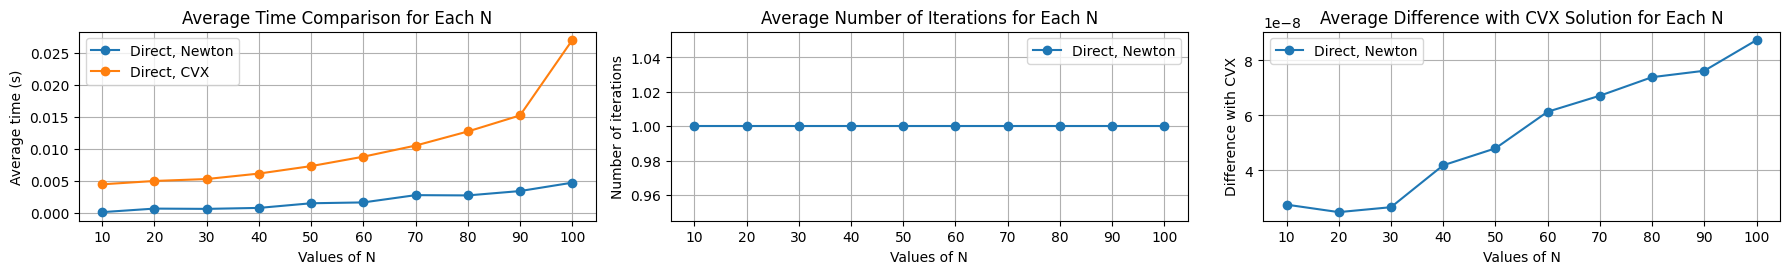

In [13]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

fig, axes = plt.subplots(1, 3, figsize=(18, 3))
axes[0].plot(dimensions, [sum(newton_time[n])/len(newton_time[n]) for n in dimensions], label='Direct, Newton', marker='o', linestyle='-')
axes[0].plot(dimensions, [sum(cvx_time[n])/len(cvx_time[n]) for n in dimensions], label='Direct, CVX', marker='o', linestyle='-')
axes[0].set_xlabel('Values of N')
axes[0].set_ylabel('Average time (s)')
axes[0].set_title('Average Time Comparison for Each N')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xticks(dimensions)

axes[1].plot(dimensions, [sum(newton_iters[n])/len(newton_iters[n]) for n in dimensions], label='Direct, Newton', marker='o', linestyle='-')
axes[1].set_xlabel('Values of N')
axes[1].set_ylabel('Number of iterations')
axes[1].set_title('Average Number of Iterations for Each N')
axes[1].legend()
axes[1].grid(True)
axes[1].set_xticks(dimensions)

axes[2].plot(dimensions, [sum(newton_eps[n])/len(newton_eps[n]) for n in dimensions], label='Direct, Newton', marker='o', linestyle='-')
axes[2].set_xlabel('Values of N')
axes[2].set_ylabel('Difference with CVX')
axes[2].set_title('Average Difference with CVX Solution for Each N')
axes[2].legend()
axes[2].grid(True)
axes[2].set_xticks(dimensions)

plt.tight_layout()
plt.show()

# print(f"Number of arithmetic operations for iteration (Direct Newton) is 17n+1\nNumber of arithmetic operations for iteration (Dual Newton) is 12n+13")

**<h1>Двойственная задача, метод Ньютона</h1>**  (пока не начинал адаптировать)

In [ ]:
def obj_func(x): # 4n-1 operations
  return np.sum(np.power(x, 4))

def get_x(A,lambda_val,b): # 3n operations
  return -1*np.cbrt(lambda_val * A / 4)

def plus_x_star(a,l): # 3 operations
  return np.cbrt((l*a)/4)

def dual_func(A,lambda_val,b): # 8n+2 operations
  l = lambda_val
  sum_term = 0
  for a in A:
    sum_term += plus_x_star(a,l)*(l*a/4 - l*a)
  objective = sum_term - b * lambda_val
  return -1*objective

def grad_dual_func(A, lambda_val, b): # 3n+1 operations
  l = lambda_val
  sum_term = 0
  for a in A:
    sum_term += plus_x_star(a,l)*a
  grad = sum_term + b
  return grad

def hess_dual_func(A, lambda_val,b): # 2n+7 operations
  l = lambda_val
  sum_term = 0
  for a in A:
    sum_term += np.cbrt(a**4)
  second_derivative = (1/(3*np.cbrt(4)*np.cbrt(l*l)))*sum_term
  return second_derivative

def solve_dual_problem_newton(l_init, A, b, cvx_opt, max_iters = 100, eps = 1e-2, gamma = 0.01):
  l = l_init
  n = len(A)
  num_iter = 0
  grad = grad_dual_func(A,l,b)
  while obj_func(get_x(A,l,b)) - cvx_opt > eps and num_iter < max_iters: # 7n+2 operations
    num_iter += 1
    grad = grad_dual_func(A,l,b) # 3n+1 operations
    hess = hess_dual_func(A,l,b) # 2n+7 operations
    newton_step = gamma*grad/hess # 2 operations
    l = l - newton_step # 1 operation
  return l, obj_func(get_x(A,l,b)), obj_func(get_x(A,l,b)) - cvx_opt, num_iter

newton_opts_dual = {n_val:[] for n_val in dimensions}
newton_eps_dual = {n_val:[] for n_val in dimensions}
newton_time_dual = {n_val:[] for n_val in dimensions}
newton_iters_dual = {n_val:[] for n_val in dimensions}
data_for_graph_dual = {}
N = 100
for n in dimensions:
  data_for_graph_dual[n] = {}
  print(f"N = {n}")
  for i in range(N):
    data_for_graph_dual[n][i] = {}
    A = a_generated[n][i]
    b = b_generated[n][i]
    cvx_opt = cvx_opts[n][i]
    num_iter = 0
    total_eps = 0
    start_time = time.time()
    for _ in range(100):
      l = abs(np.random.randn(1))
      l_star, min_value, eps, iters = solve_dual_problem_newton(l, A, b, cvx_opt)
      num_iter += iters
      total_eps += eps

      data_for_graph_dual[n][i][_] = {
                                      'iter': iters,
                                      'eps': eps
                                      }
    elapsed_time = time.time() - start_time
    newton_time_dual[n].append(elapsed_time/100)
    newton_iters_dual[n].append(num_iter/100)
    newton_eps_dual[n].append(total_eps/100)
    newton_opts_dual[n].append(min_value)

N = 10
N = 20
N = 30
N = 40
N = 50
N = 60
N = 70
N = 80
N = 90
N = 100


**<h1>Время работы и среднее число итераций</h1>**

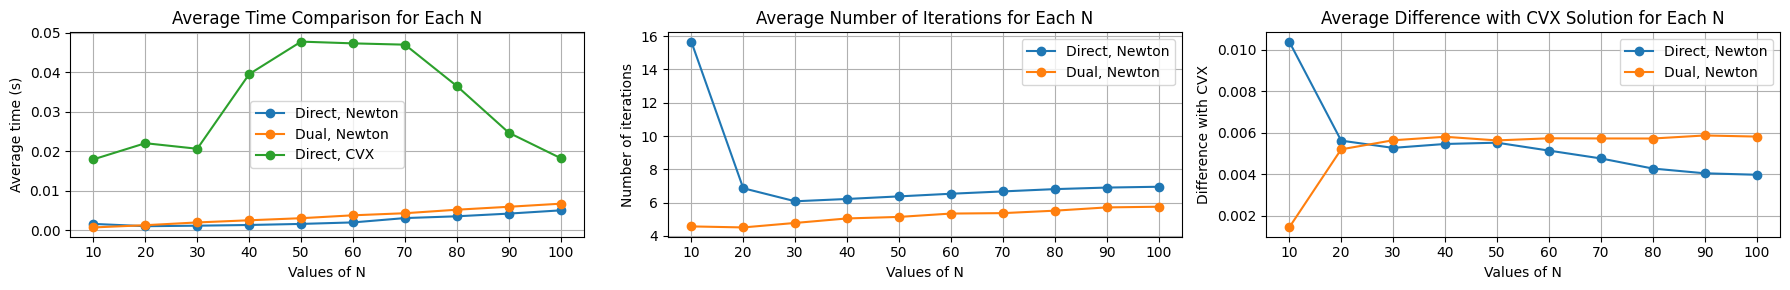

Number of arithmetic operations for iteration (Direct Newton) is 17n+1
Number of arithmetic operations for iteration (Dual Newton) is 12n+13


In [ ]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

fig, axes = plt.subplots(1, 3, figsize=(18, 3))
axes[0].plot(dimensions, [sum(newton_time[n])/len(newton_time[n]) for n in dimensions], label='Direct, Newton', marker='o', linestyle='-')
axes[0].plot(dimensions, [sum(newton_time_dual[n])/len(newton_time_dual[n]) for n in dimensions], label='Dual, Newton', marker='o', linestyle='-')
axes[0].plot(dimensions, [sum(cvx_time[n])/len(cvx_time[n]) for n in dimensions], label='Direct, CVX', marker='o', linestyle='-')
axes[0].set_xlabel('Values of N')
axes[0].set_ylabel('Average time (s)')
axes[0].set_title('Average Time Comparison for Each N')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xticks(dimensions)

axes[1].plot(dimensions, [sum(newton_iters[n])/len(newton_iters[n]) for n in dimensions], label='Direct, Newton', marker='o', linestyle='-')
axes[1].plot(dimensions, [sum(newton_iters_dual[n])/len(newton_iters_dual[n]) for n in dimensions], label='Dual, Newton', marker='o', linestyle='-')
axes[1].set_xlabel('Values of N')
axes[1].set_ylabel('Number of iterations')
axes[1].set_title('Average Number of Iterations for Each N')
axes[1].legend()
axes[1].grid(True)
axes[1].set_xticks(dimensions)

axes[2].plot(dimensions, [sum(newton_eps[n])/len(newton_eps[n]) for n in dimensions], label='Direct, Newton', marker='o', linestyle='-')
axes[2].plot(dimensions, [sum(newton_eps_dual[n])/len(newton_eps_dual[n]) for n in dimensions], label='Dual, Newton', marker='o', linestyle='-')
axes[2].set_xlabel('Values of N')
axes[2].set_ylabel('Difference with CVX')
axes[2].set_title('Average Difference with CVX Solution for Each N')
axes[2].legend()
axes[2].grid(True)
axes[2].set_xticks(dimensions)

plt.tight_layout()
plt.show()

print(f"Number of arithmetic operations for iteration (Direct Newton) is 17n+1\nNumber of arithmetic operations for iteration (Dual Newton) is 12n+13")

**<h1>Зависимость точности от числа итераций</h1>**

In [ ]:
number_start_points = 100
def get_info(data):
    info = []
    for dimension in data:
        for test_sample in data[dimension]:
            for start_point in data[dimension][test_sample]:
                info.append((data[dimension][test_sample][start_point]['iter'], data[dimension][test_sample][start_point]['eps']))
            break
        break
    return info[:number_start_points]

In [ ]:
info_for_graph = get_info(data_for_graph)
info_for_graph_dual = get_info(data_for_graph_dual)

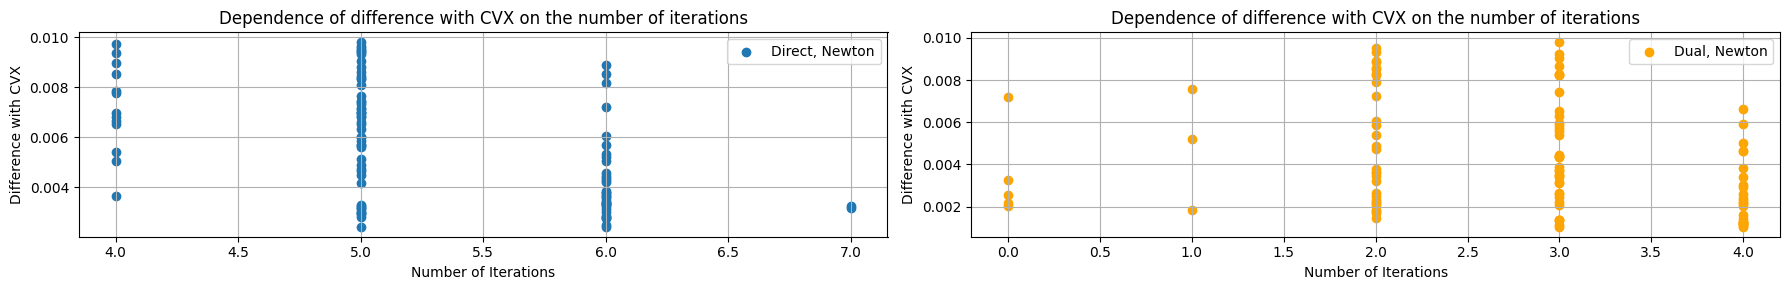

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 3))
axes[0].scatter([item[0] for item in info_for_graph], [item[1] for item in info_for_graph], label='Direct, Newton', marker='o', linestyle='-')
axes[0].set_xlabel('Number of Iterations')
axes[0].set_ylabel('Difference with CVX')
axes[0].set_title('Dependence of difference with CVX on the number of iterations')
axes[0].legend()
axes[0].grid(True)

axes[1].scatter([item[0] for item in info_for_graph_dual], [item[1] for item in info_for_graph_dual], label='Dual, Newton', marker='o', linestyle='-', color = 'orange')
axes[1].set_xlabel('Number of Iterations')
axes[1].set_ylabel('Difference with CVX')
axes[1].set_title('Dependence of difference with CVX on the number of iterations')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


**<h2>Усреднее точность по итерациям</h2>**

In [ ]:
def get_grouped_data(data):
    grouped_data = {}
    for x, y in data:
        if x not in grouped_data:
            grouped_data[x] = []
        grouped_data[x].append(y)
    return grouped_data

def average_eps(data):
    for iter_ in data:
        data[iter_] = np.mean(data[iter_])
    return data

In [ ]:
data_info = average_eps(get_grouped_data(info_for_graph))
data_info_dual = average_eps(get_grouped_data(info_for_graph_dual))

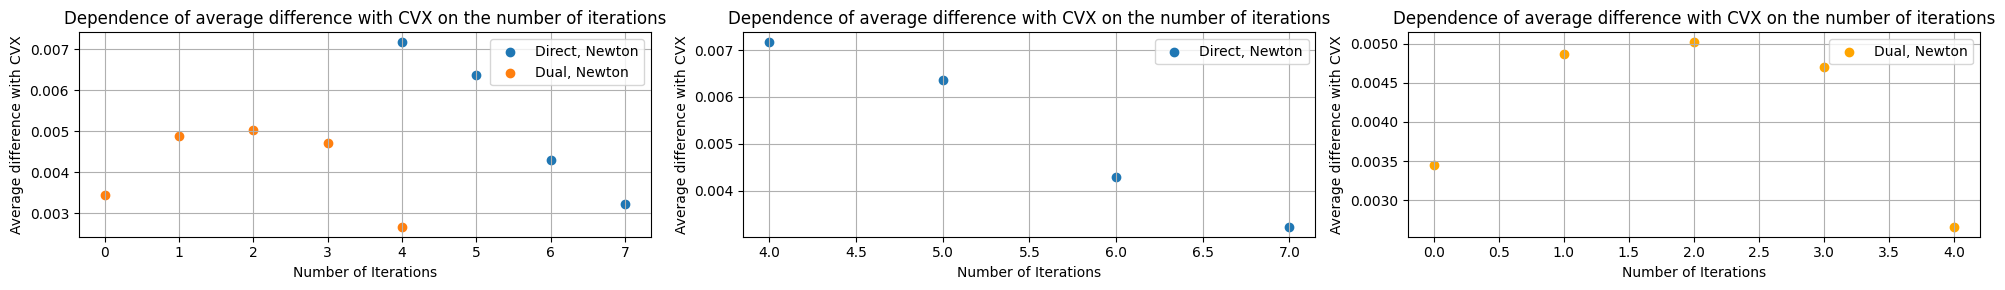

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 3))
axes[0].scatter(list(data_info.keys()), list(data_info.values()) , label='Direct, Newton', marker='o', linestyle='-')
axes[0].scatter(list(data_info_dual.keys()), list(data_info_dual.values()) , label='Dual, Newton', marker='o', linestyle='-')
axes[0].set_xlabel('Number of Iterations')
axes[0].set_ylabel('Average difference with CVX')
axes[0].set_title('Dependence of average difference with CVX on the number of iterations')
axes[0].legend()
axes[0].grid(True)

axes[1].scatter(list(data_info.keys()), list(data_info.values()) , label='Direct, Newton', marker='o', linestyle='-')
axes[1].set_xlabel('Number of Iterations')
axes[1].set_ylabel('Average difference with CVX')
axes[1].set_title('Dependence of average difference with CVX on the number of iterations')
axes[1].legend()
axes[1].grid(True)

axes[2].scatter(list(data_info_dual.keys()), list(data_info_dual.values()) , label='Dual, Newton', marker='o', linestyle='-', color = 'orange')
axes[2].set_xlabel('Number of Iterations')
axes[2].set_ylabel('Average difference with CVX')
axes[2].set_title('Dependence of average difference with CVX on the number of iterations')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

**<h1>Выводы</h1>**
- Метод Ньютона для прямой и двойственной задач работает быстрее, чем CVX солвер (ускорение от 5 до 20%).
- Для двойственного метода в среднем требуется на 1 итерацию меньше, чем для прямого.
- Точность ответов прямого и двойственного методов практически не отличаются.
- Для прямой задачи на одной итерации требуется 17n+1 арифметических операций, для двойственной задачи 12n+13 операций.
- Для прямой задачи с ростом числа итераций возрастает точность, для двойственной задачи изменение точности менее заметное.